In [8]:
import os
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
import cv2
from skimage import color
from scipy.ndimage import binary_fill_holes


In [25]:
def scaled(img, scale=20000):
    dtype = img.dtype    
    epsilon = 0.99    
    _max = np.quantile(img[img>0], epsilon)
    scaled = (img * (scale / _max)).astype(dtype) # scale the image from original values to e.g., 30000/10000
    del img
    return scaled

def equalized(fixed, cliplimit=2):    
    clahe = cv2.createCLAHE(clipLimit=cliplimit, tileGridSize=(8, 8))
    fixed = clahe.apply(fixed)
    return fixed

def mask_with_contours(img):

    new_img = color.rgb2gray(img)
    new_img *= 255 # or any coefficient
    new_img = new_img.astype(np.uint8)
    new_img[(new_img > 200)] = 255
    
    lowerbound = 200
    upperbound = 255
    #all pixels value above lowerbound will  be set to upperbound 
    _, thresh = cv2.threshold(new_img.copy(), lowerbound, upperbound, cv2.THRESH_BINARY_INV)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(50,50))
    thresh = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (8,8))
    smoothed = cv2.morphologyEx(thresh, cv2.MORPH_ERODE, kernel)
    inverted_thresh = cv2.bitwise_not(smoothed)
    filled_thresh = binary_fill_holes(inverted_thresh).astype(np.uint8)
    #return cv2.bitwise_and(img,img, mask=filled_thresh)
    return cv2.bitwise_not(img, filled_thresh)
    #return filled_thresh

def clean(img, mask):
    return cv2.bitwise_and(img, img, mask=mask)

In [26]:
animal = 'MD592'
BASE_DIR = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps'
filepath = os.path.join(BASE_DIR, 'C1/thumbnail', '100.tif')
maskpath = os.path.join(BASE_DIR, 'masks/C1/thumbnail_masked', '100.tif')


In [ ]:
#For bigarr, look at 15812x43685, 16816x44463
startrow = 43685
endrow = 44463
startcol = 15812
endcol = 16816

In [27]:
img = io.imread(filepath)
print(f'dtype={img.dtype} shape={img.shape}')
mask = io.imread(maskpath)
print(f'dtype={mask.dtype} shape={mask.shape}')

dtype=uint8 shape=(624, 841, 3)
dtype=uint8 shape=(624, 841)


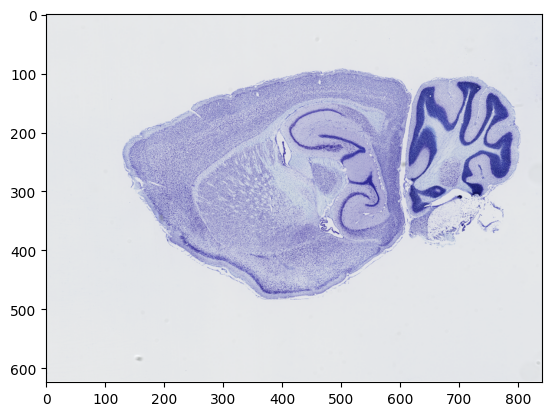

In [6]:
plt.imshow(img)

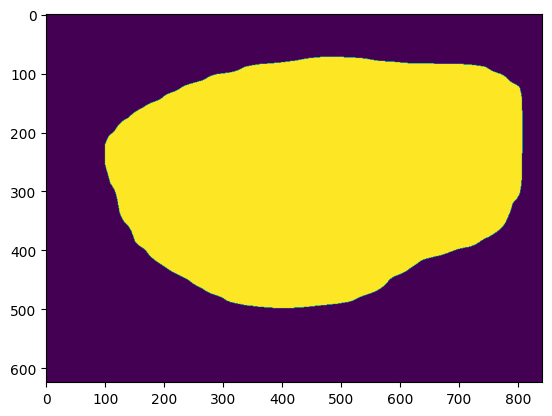

In [28]:
plt.imshow(mask)

74
234
dtype=uint8 shape=(624, 841, 3) first=[0 0 0]


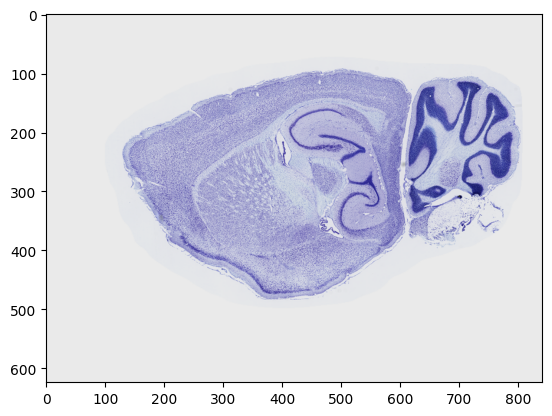

In [46]:
newimg = clean(img, mask)
white = np.where(mask==255)
whiterows = white[0]
firstrow = whiterows[1]
print(firstrow)
print(np.max(newimg[firstrow]))


print(f'dtype={newimg.dtype} shape={newimg.shape} first={first}')
newimg[newimg == 0] = 234
plt.imshow(newimg)

In [ ]:
%%time
#scale = 2**16 - 1
scale = 20000
bigarr_scaled = scaled(bigarr, scale)
print(f'dtype={bigarr_scaled.dtype} shape={bigarr_scaled.shape}')
cropped = bigarr_scaled[startrow:endrow, startcol:endcol]
print(f'dtype={cropped.dtype} shape={cropped.shape}')
outpath = os.path.join(DIR, 'cropped_test.tif')
io.imsave(outpath, cropped)

In [ ]:
scale = 2**16 - 1
cropped_scaled = scaled(cropped, scale)
outpath = os.path.join(DIR, f'cropped_scaled_{scale}.tif')
if not os.path.exists(outpath):
    io.imsave(outpath, cropped_scaled)